# Cora Dataset

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx, to_dense_adj

In [15]:
dataset = Planetoid(root="data", name="Cora")

print(f"num documents : {dataset.num_features}")
print(f"num classes : {dataset.num_classes}")

data = dataset[0]

print(f"Size information matrix : {data.x.shape}")
print(f"Size target vector : {data.y.shape}")
print(f"Size trainset : {data.train_mask.sum()}")
print(f"Size testset : {data.test_mask.sum()}")

print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')


num documents : 1433
num classes : 7
Size information matrix : torch.Size([2708, 1433])
Size target vector : torch.Size([2708])
Size trainset : 140
Size testset : 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


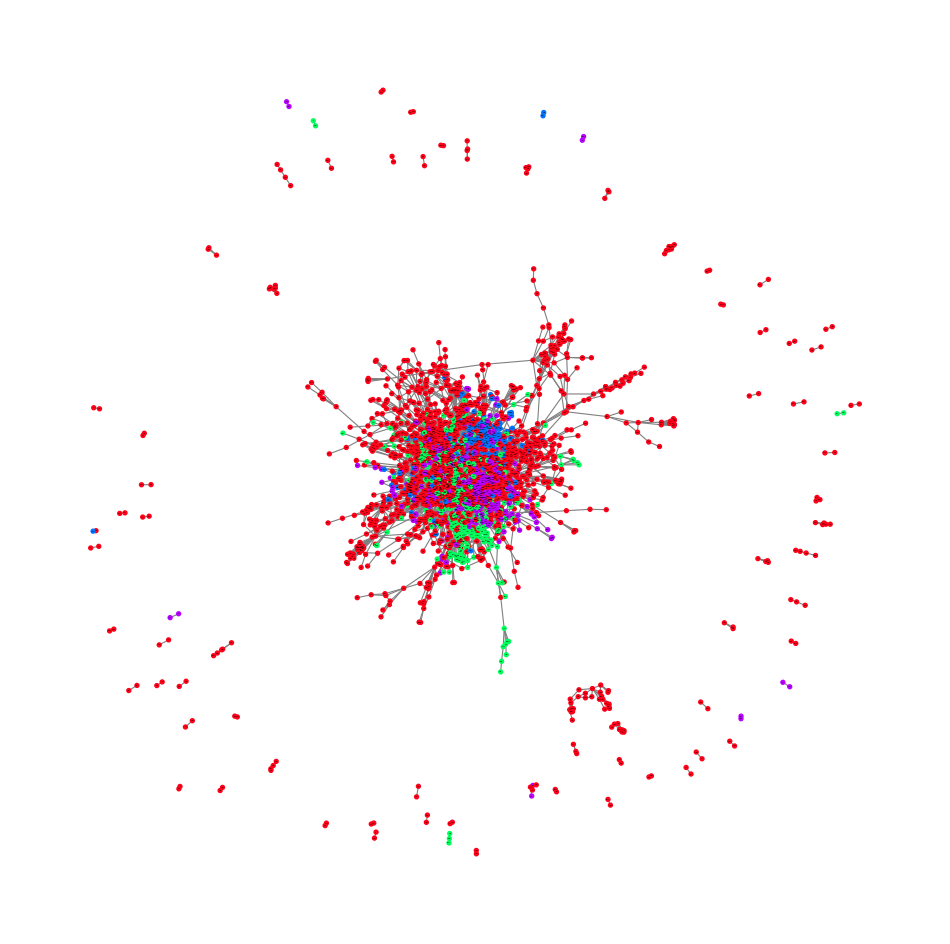

In [3]:
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(12,12))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=True,
                node_size=8,
                node_color=data.y,
                cmap="hsv",
                vmin=-2,
                vmax=3,
                width=0.8,
                edge_color="grey",
                font_size=0
                )
plt.show()

# Graph Convolution Network for Classification

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from utils import accuracy

from model import GCN

In [19]:
X = data.x
y = data.y
A = to_dense_adj(data.edge_index).squeeze(0)

train_index = dataset.train_mask==True
val_index = dataset.val_mask==True
test_index = dataset.test_mask==True

In [28]:
EPOCHS = 200
LEARNING_RATE = 1e-2

model = GCN(in_channels=dataset.num_features, hidden_dim=16, out_channels=dataset.num_classes, adj = A)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=5e-4)

In [29]:
losses = []
train_accs = []
val_accs = []

best_model = model
iter_loss = 0
best_val_acc = -np.inf

for epoch in range(EPOCHS):

    pred = model(X)
    loss = criterion(pred[train_index], y[train_index])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.detach())

    if epoch%10==0:
        with torch.no_grad():
            model.eval()

            preds = model(X)
            pred_train, y_train = preds[train_index], y[train_index]
            pred_val, y_val = preds[val_index], y[val_index]

            train_acc = accuracy(y_train, torch.argmax(pred_train, axis=1))
            val_acc = accuracy(y_val, torch.argmax(pred_val, axis=1))

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model = model
            else : 
                iter_loss+=1

            if iter_loss>=10:
                print('early stopping reached')
                break

            train_accs.append(train_acc)
            val_accs.append(val_acc)

            print(f"For epoch {epoch}, Train Accuracy : {train_acc}")
            print(f"For epoch {epoch}, Val Accuracy : {val_acc}")

            model.train()

For epoch 0, Train Accuracy : 0.2571428716182709
For epoch 0, Val Accuracy : 0.1899999976158142
For epoch 10, Train Accuracy : 0.9357143044471741
For epoch 10, Val Accuracy : 0.6660000085830688
For epoch 20, Train Accuracy : 0.9928571581840515
For epoch 20, Val Accuracy : 0.7860000133514404
For epoch 30, Train Accuracy : 1.0
For epoch 30, Val Accuracy : 0.7919999957084656
For epoch 40, Train Accuracy : 1.0
For epoch 40, Val Accuracy : 0.7799999713897705
For epoch 50, Train Accuracy : 1.0
For epoch 50, Val Accuracy : 0.7720000147819519
For epoch 60, Train Accuracy : 1.0
For epoch 60, Val Accuracy : 0.7739999890327454
For epoch 70, Train Accuracy : 1.0
For epoch 70, Val Accuracy : 0.7760000228881836
For epoch 80, Train Accuracy : 1.0
For epoch 80, Val Accuracy : 0.7699999809265137
For epoch 90, Train Accuracy : 1.0
For epoch 90, Val Accuracy : 0.765999972820282
For epoch 100, Train Accuracy : 1.0
For epoch 100, Val Accuracy : 0.777999997138977
For epoch 110, Train Accuracy : 1.0
For epoc

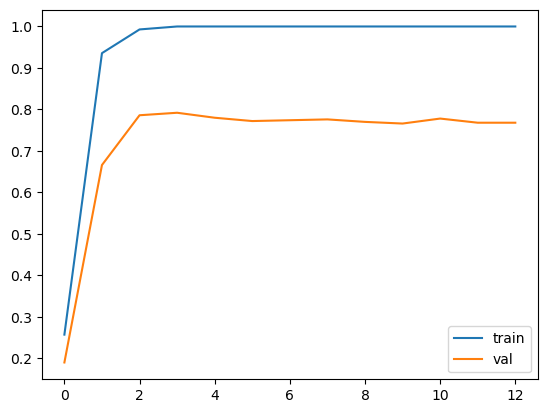

In [30]:
plt.plot(train_accs, label='train')
plt.plot(val_accs, label = 'val')
plt.legend()

In [33]:
preds = best_model(X)
preds_test, true_test = preds[test_index], y[test_index]
test_acc = accuracy(true_test, torch.argmax(preds_test, axis=1))   
print(f'accuracy for the best model on testset is : {test_acc}')

accuracy for the best model on testset is : 0.7870000004768372


# Graph Convolution Network for 2D representation

In [11]:
EPOCHS = 1000
LEARNING_RATE = 1e-2

model = GCN(in_channels=dataset.num_features, hidden_dim=2, out_channels=dataset.num_classes, adj = A, return_hidden=True)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=5e-4)

In [12]:
losses = []
train_accs = []
test_accs = []

for epoch in range(EPOCHS):

    pred, z = model(X)
    loss = criterion(pred[train_index], y[train_index])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.detach())

    if epoch%10==0:
        with torch.no_grad():
            model.eval()

            preds, z = model(X)
            pred_train, y_train = preds[train_index], y[train_index]
            pred_test, y_test = preds[test_index], y[test_index]

            train_acc = accuracy(y_train, torch.argmax(pred_train, axis=1))
            test_acc = accuracy(y_test, torch.argmax(pred_test, axis=1))
            train_accs.append(train_acc)
            test_accs.append(test_acc)

            print(f"For epoch {epoch}, Train Accuracy : {train_acc}")
            print(f"For epoch {epoch}, Test Accuracy : {test_acc}")

            model.train()

For epoch 0, Train Accuracy : 0.1428571492433548
For epoch 0, Test Accuracy : 0.1459999978542328
For epoch 10, Train Accuracy : 0.2142857164144516
For epoch 10, Test Accuracy : 0.17900000512599945
For epoch 20, Train Accuracy : 0.2142857164144516
For epoch 20, Test Accuracy : 0.16500000655651093
For epoch 30, Train Accuracy : 0.37857142090797424
For epoch 30, Test Accuracy : 0.18799999356269836
For epoch 40, Train Accuracy : 0.4285714328289032
For epoch 40, Test Accuracy : 0.20600000023841858
For epoch 50, Train Accuracy : 0.5
For epoch 50, Test Accuracy : 0.24300000071525574
For epoch 60, Train Accuracy : 0.699999988079071
For epoch 60, Test Accuracy : 0.3529999852180481
For epoch 70, Train Accuracy : 0.7714285850524902
For epoch 70, Test Accuracy : 0.3880000114440918
For epoch 80, Train Accuracy : 0.8142856955528259
For epoch 80, Test Accuracy : 0.41499999165534973
For epoch 90, Train Accuracy : 0.8214285969734192
For epoch 90, Test Accuracy : 0.42800000309944153
For epoch 100, Train

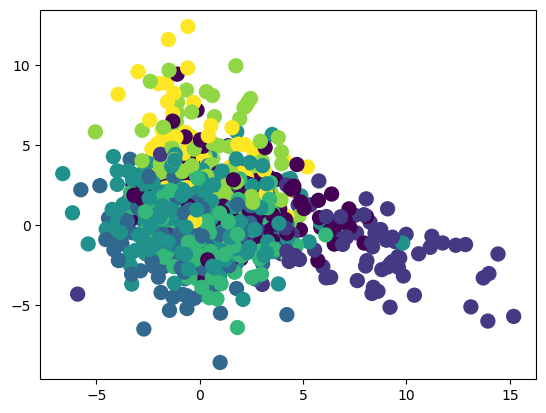

In [13]:
plt.scatter(z[test_index].T[0].detach(), z[test_index].T[1].detach(), c=y[test_index], s=100)